In [79]:
import mne

d_path = "/Users/szymbierz/Desktop/notebooks/statystyka/eeg/eeg_files/20241017_kp.bdf"

#kanały zewnętrzne

ch_eog = ["EXG1","EXG2"] #ruchy gałek ocznych
ch_ecg = ["EXG3","EXG4"]

#lista niepotrzebnych kanałów

ch_exclude = [f"EXG{i}" for i in range(5,9)]

#zakresy pasm filtra

bandpass_low = 0.2 #dolny zakres
bandpass_high = 30 #górny zakres
notch = 50 #

#wczytanie surowych danych

raw = mne.io.read_raw_bdf(d_path,
                          preload=True,
                          eog=ch_eog,
                          misc=ch_ecg,
                          exclude=ch_exclude)

#ustawienie montażu elektrod (standard dla sprzętu)

raw.set_montage("biosemi64")

#Filtry
raw.notch_filter(notch)
raw.filter(bandpass_low,bandpass_high)

raw.set_eeg_reference("average") #referencja względem średniej sygnału z elektrod

raw_ica = raw.copy() #skopiowanie sygnału aby zastosować filtr przed ica

raw_ica.filter(l_freq=1.,h_freq=30.)

ica = mne.preprocessing.ICA(n_components=20,
                            random_state=42,
                            max_iter="auto")
ica.fit(raw_ica)

Extracting EDF parameters from /Users/szymbierz/Desktop/notebooks/statystyka/eeg/eeg_files/20241017_kp.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2928639  =      0.000 ...  1430.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 13517 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 33793 samples (16.500 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 34.8s.


<ICA | raw data decomposition, method: fastica (fit in 37 iterations on 2928640 samples), 20 ICA components (64 PCA components available), channel types: eeg, no sources marked for exclusion>

In [80]:


eog_scores = ica.score_sources(raw, ch_name=ch_eog)
ecg_scores = ica.score_sources(raw, ch_name=ch_ecg)
print(eog_scores)
print(ecg_scores)

TypeError: score_sources() got an unexpected keyword argument 'ch_name'

In [108]:
explained_var_ratio = ica.get_explained_variance_ratio(raw)
for channel_type, ratio in explained_var_ratio.items():
    print(f"Fraction of {channel_type} variance explained by all components: {ratio*100:.2f}%")

Fraction of eeg variance explained by all components: 97.64%


Creating RawArray with float64 data, n_channels=22, n_times=2928640
    Range : 0 ... 2928639 =      0.000 ...  1430.000 secs
Ready.


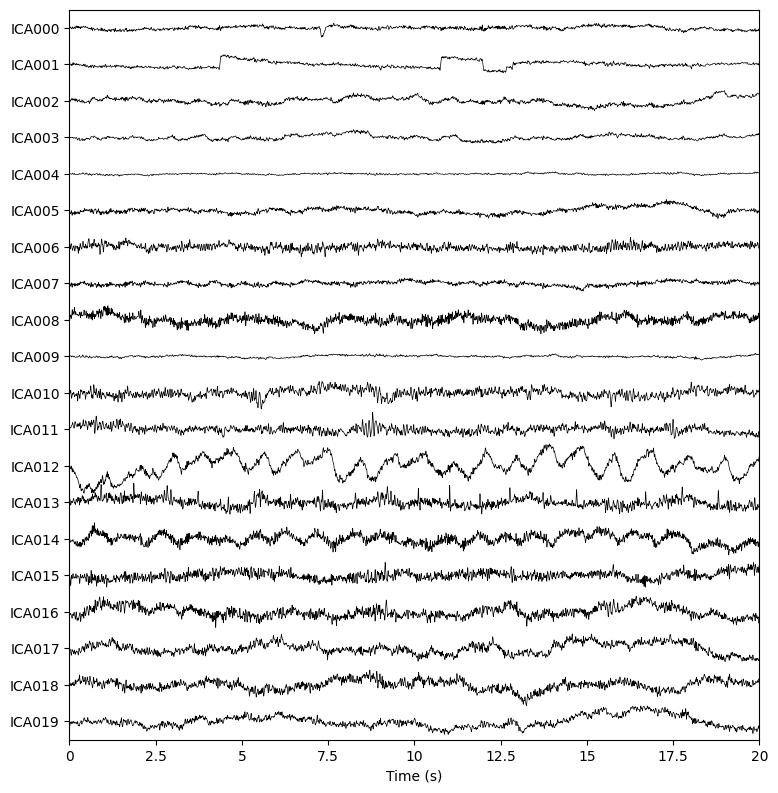

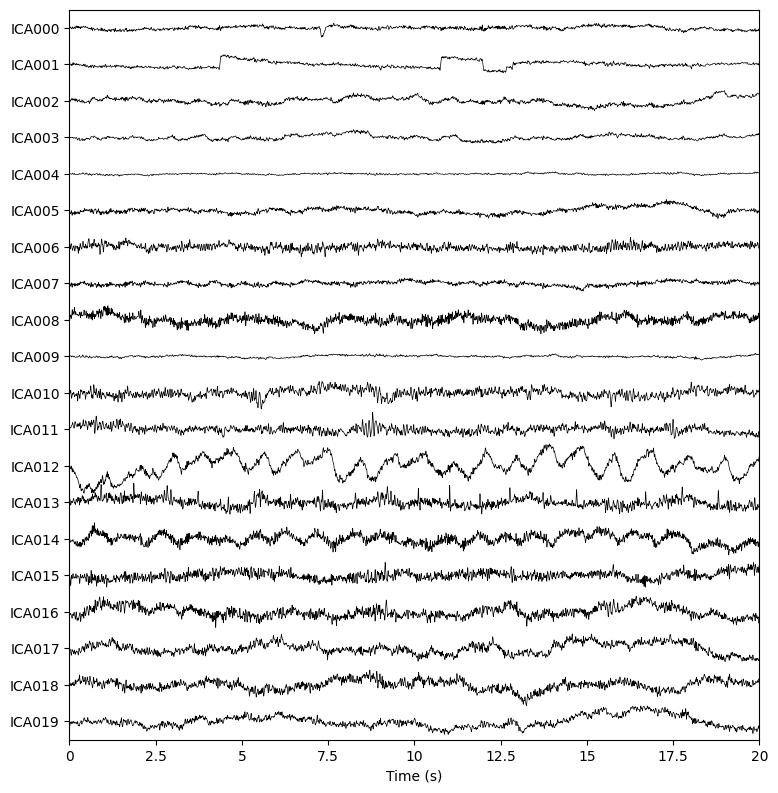

In [82]:
raw.load_data()
ica.plot_sources(raw, show_scrollbars=False)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
715 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
715 matching events found
No baseline correction applied
0 projection items activated


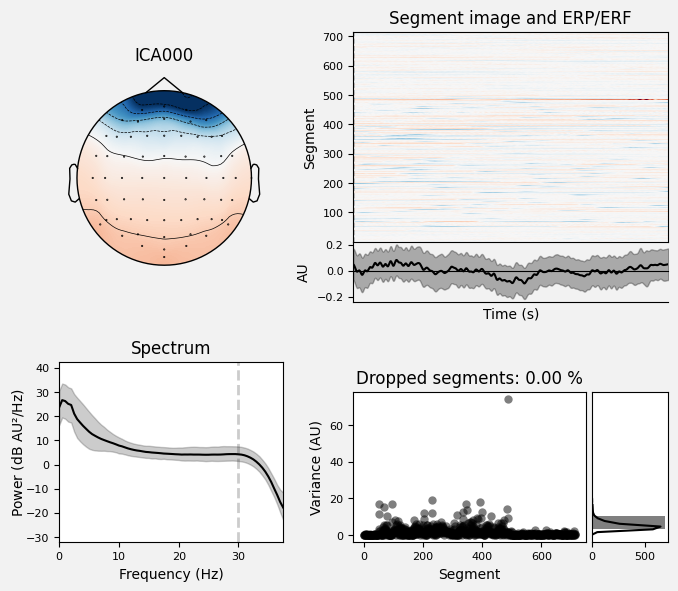

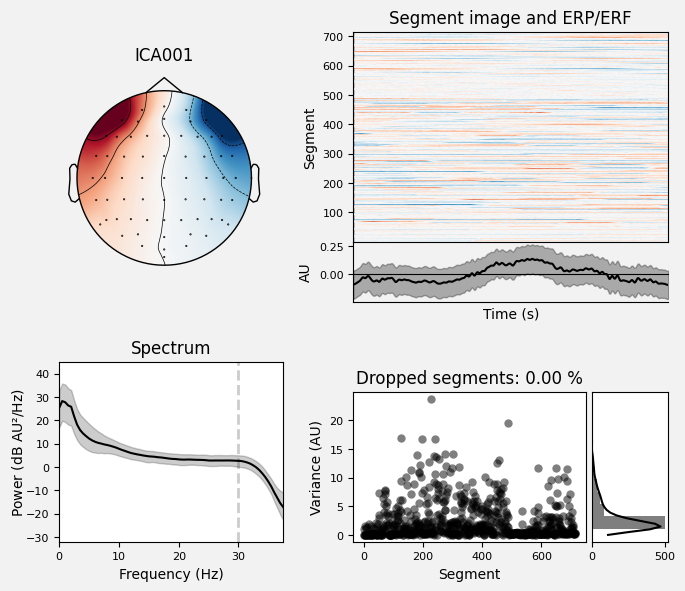

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [83]:
ica.plot_properties(raw, picks=[0, 1])

Using EOG channels: EXG1, EXG2
EOG channel index for this subject is: [64 65]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EXG2 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 421 significant peaks
Number of EOG events detected: 421
Not setting metadata
421 matching events found
No baseline correction applied
Using data from preloaded Raw for 421 events and 2049 original time points ...
0 bad epochs dropped
Applying baseli

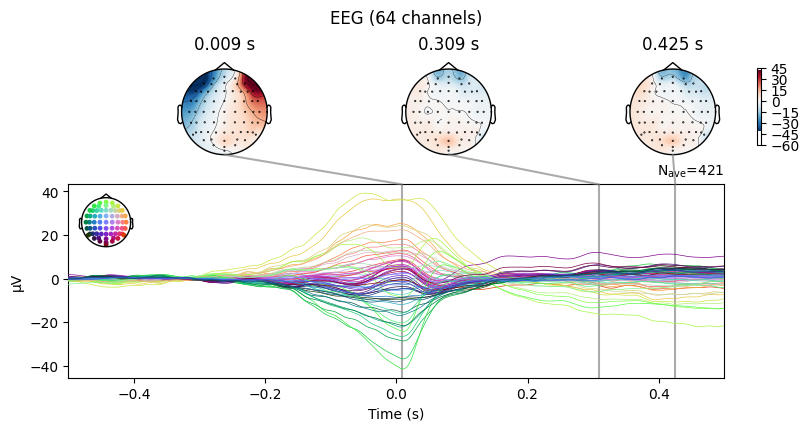

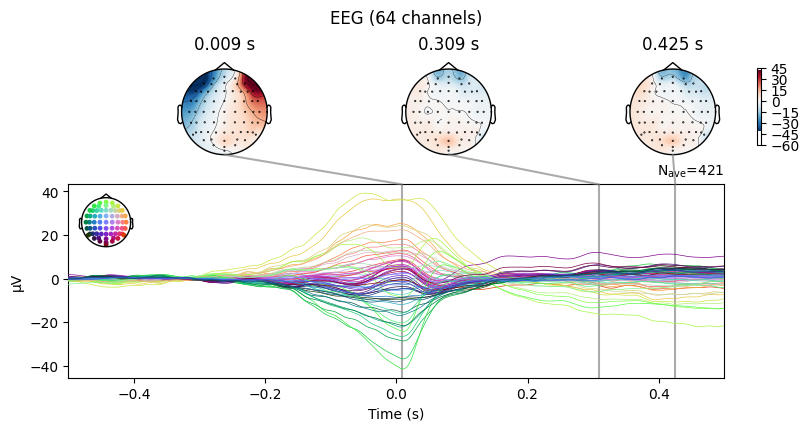

In [84]:
from mne.preprocessing import create_eog_epochs

eog_evoked = create_eog_epochs(raw).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint()

Using EOG channels: EXG1, EXG2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
715 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
715 matching events found
No baseline correction applied
0 projection items activated


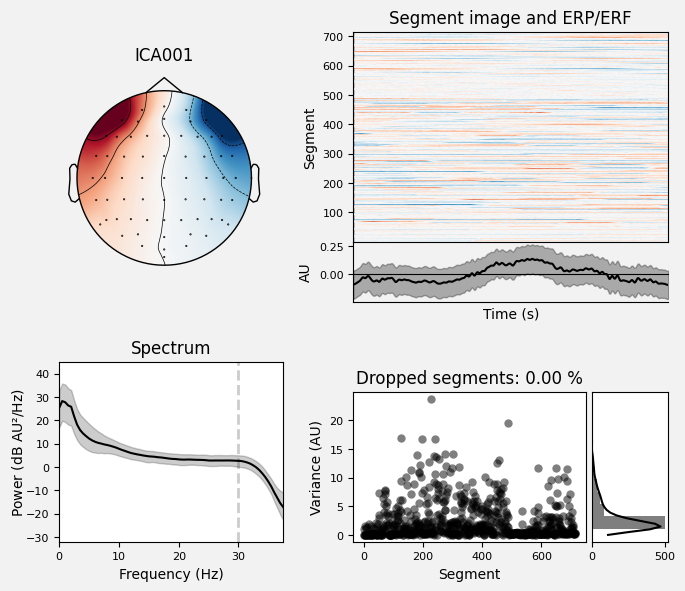

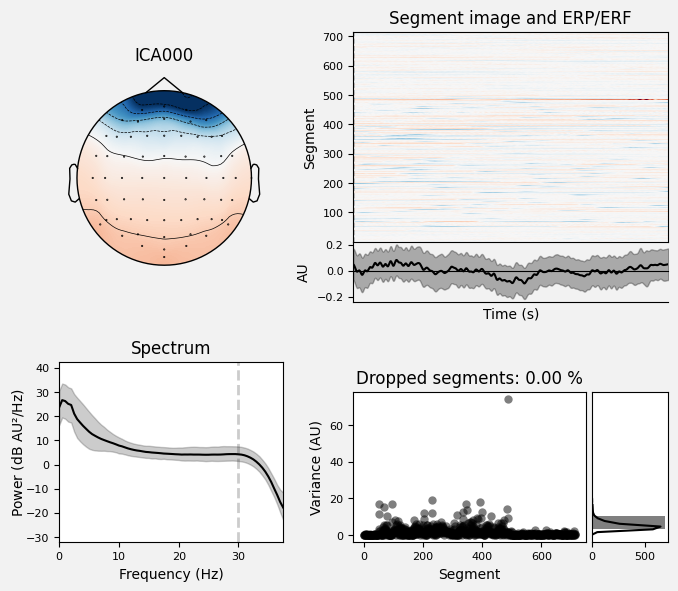

Creating RawArray with float64 data, n_channels=22, n_times=2928640
    Range : 0 ... 2928639 =      0.000 ...  1430.000 secs
Ready.


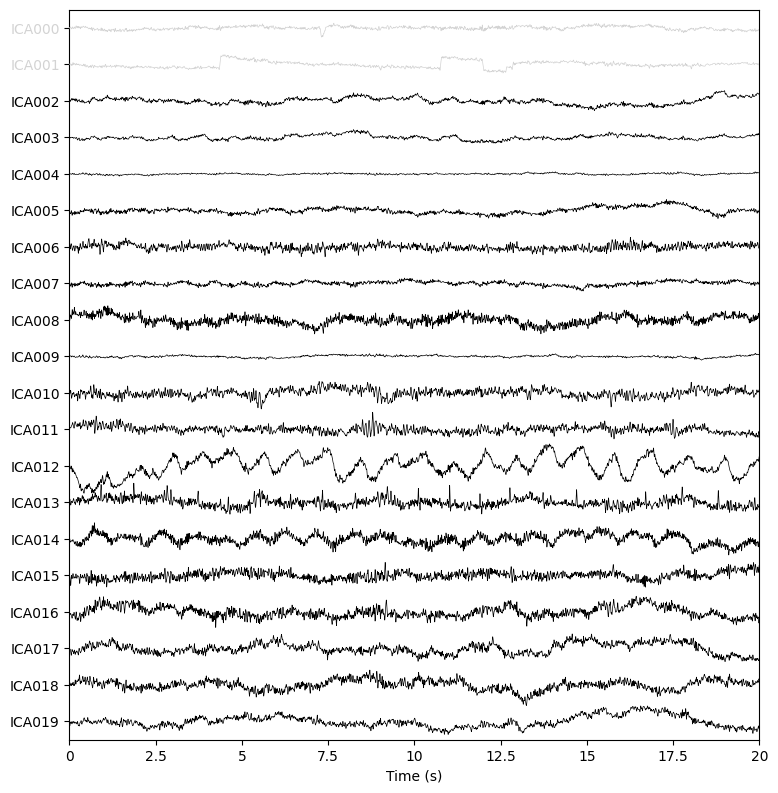

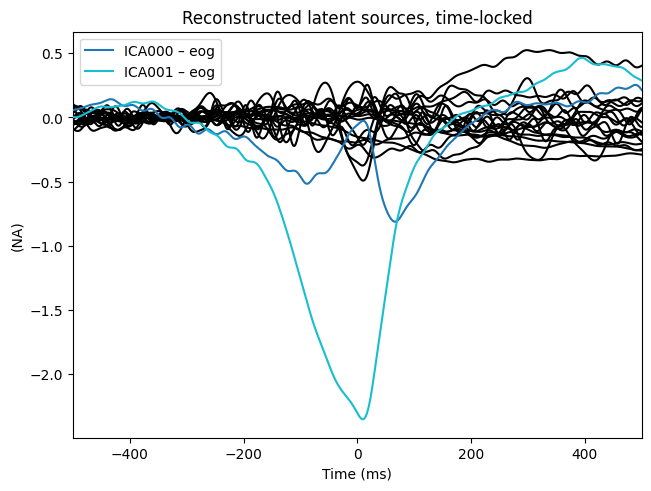

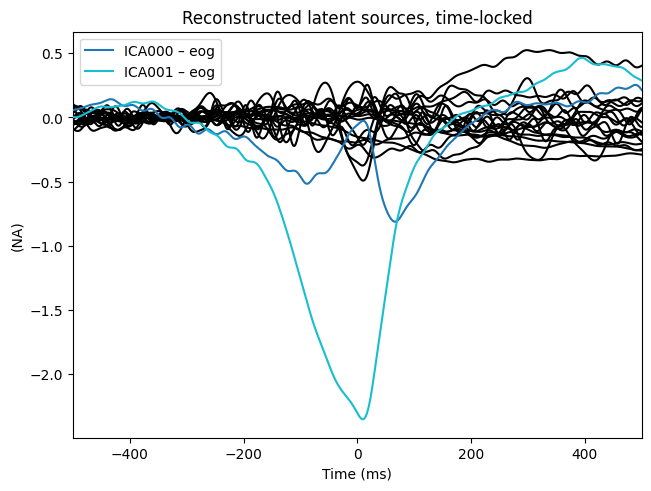

In [86]:
ica.exclude = []
# find which ICs match the EOG pattern
eog_indices, eog_scores = ica.find_bads_eog(raw)
ica.exclude = eog_indices


# plot diagnostics
ica.plot_properties(raw, picks=eog_indices)

# plot ICs applied to raw data, with EOG matches highlighted
ica.plot_sources(raw, show_scrollbars=False)

# plot ICs applied to the averaged EOG epochs, with EOG matches highlighted
ica.plot_sources(eog_evoked)

In [87]:
eog_indices, eog_scores = ica.find_bads_eog(raw)
ecg_indices, ecg_scores = ica.find_bads_ecg(raw, ch_name="EXG3")
print("EOG components:", eog_indices)
print("ECG components:", ecg_indices)

Using EOG channels: EXG1, EXG2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Using threshold: 0.12 for CTPS ECG detection
Using channel EXG3 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 20480 samples (10.000 s)

Number of ECG events detected : 1377 (average pulse 57.77622377622378 / min.)
Not setting metadata
1377 matching events found
No baseline correction applied
Using data from preloaded Raw for 1377 events and 2049 original time points ...
0 bad epochs dropped
EOG components: [1, 0]
ECG components: [13, 8, 14, 12, 7]


In [88]:
print(ecg_scores)

[0.05739483 0.05149278 0.04096872 0.09988286 0.04485638 0.11856002
 0.04450729 0.14096905 0.20787997 0.04762029 0.0519199  0.04212917
 0.15979376 0.53751499 0.19625281 0.03338721 0.05246191 0.03958074
 0.05048324 0.03799131]


In [89]:
print(eog_scores)

[array([ 0.65596232,  0.35875971,  0.05036431,  0.03580061, -0.00632606,
        0.03938824, -0.17219242,  0.02754573, -0.01341852,  0.02679659,
        0.19679893,  0.29138397,  0.00653672, -0.00905654,  0.00821427,
        0.04909211,  0.0362859 , -0.02659569, -0.09660459,  0.0103268 ]), array([-8.48652611e-02,  9.05773927e-01, -1.34216065e-04,  1.53270444e-02,
       -3.76013276e-03,  1.44775084e-02, -1.63436453e-01, -1.96943554e-02,
       -4.06486421e-02, -7.82191952e-03,  1.17250064e-01,  2.14843218e-01,
        6.04073230e-03, -2.25395760e-02, -1.43848504e-02,  4.66492170e-02,
        2.44754696e-02, -8.92117081e-03, -5.98099006e-02,  1.12295624e-02])]


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
715 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
715 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
715 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
715 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
715 matching events found
No baseline correction applied
0 projection items activated


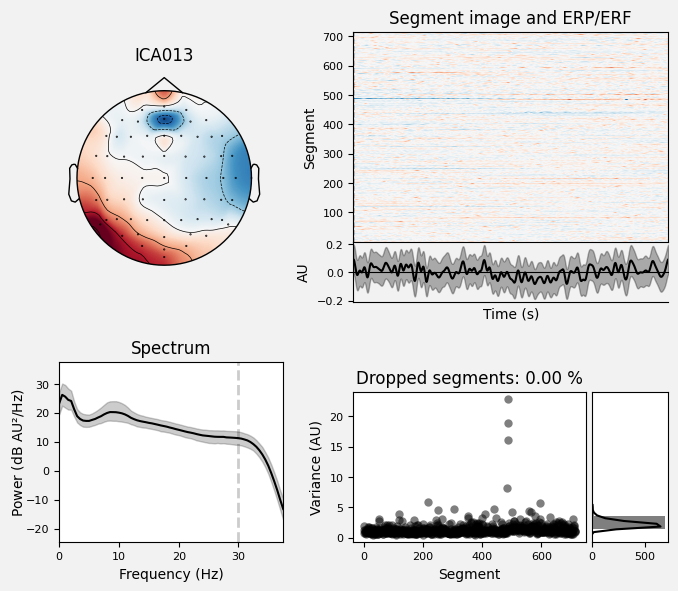

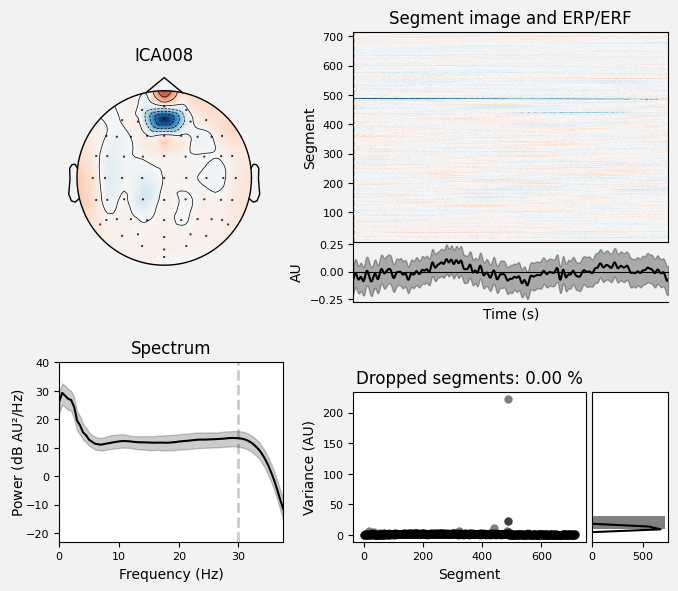

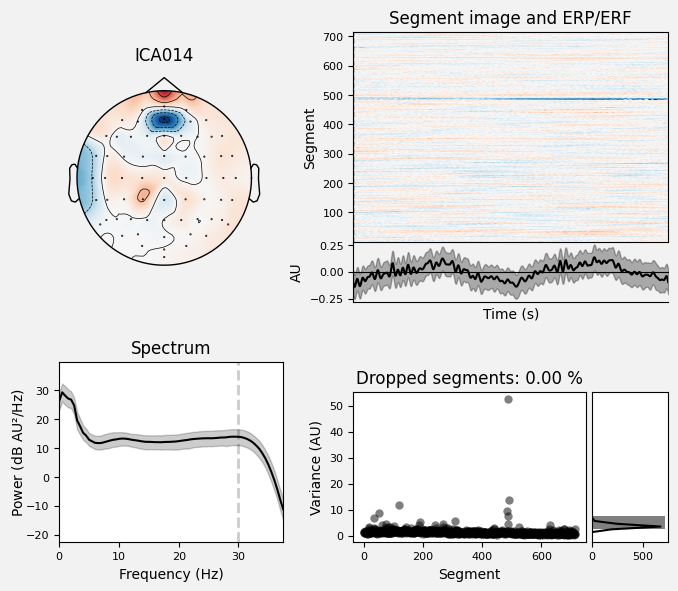

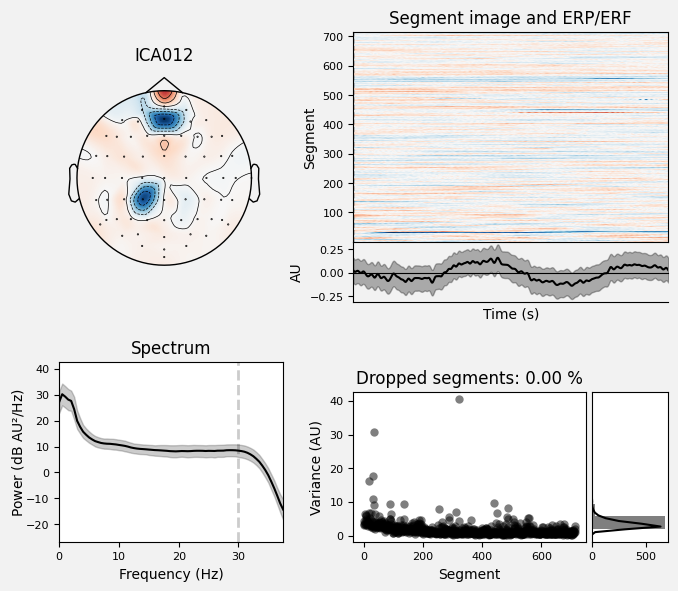

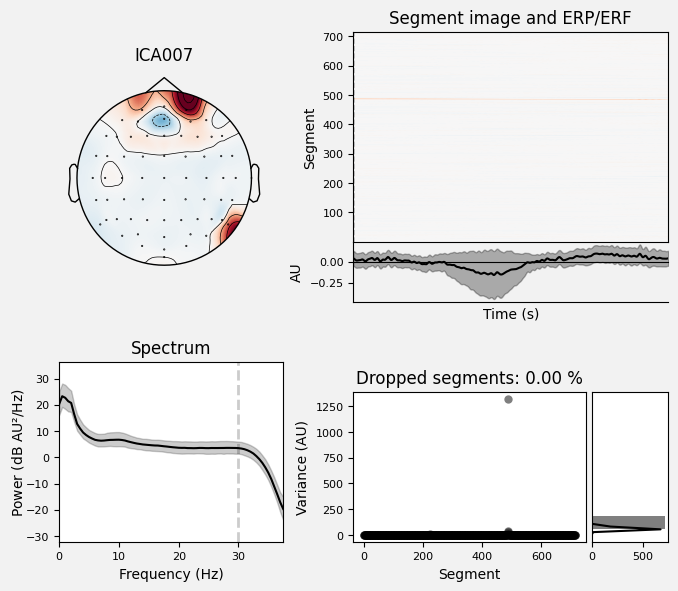

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [90]:
ica.plot_properties(raw, picks=ecg_indices)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
715 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
715 matching events found
No baseline correction applied
0 projection items activated


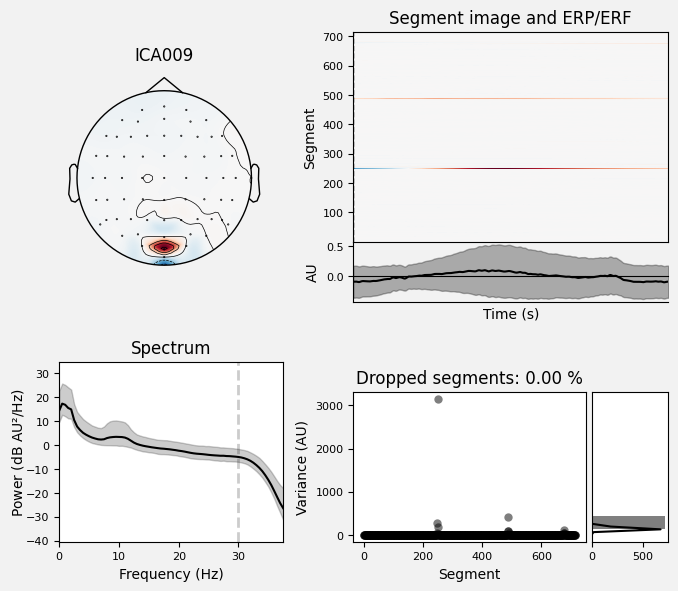

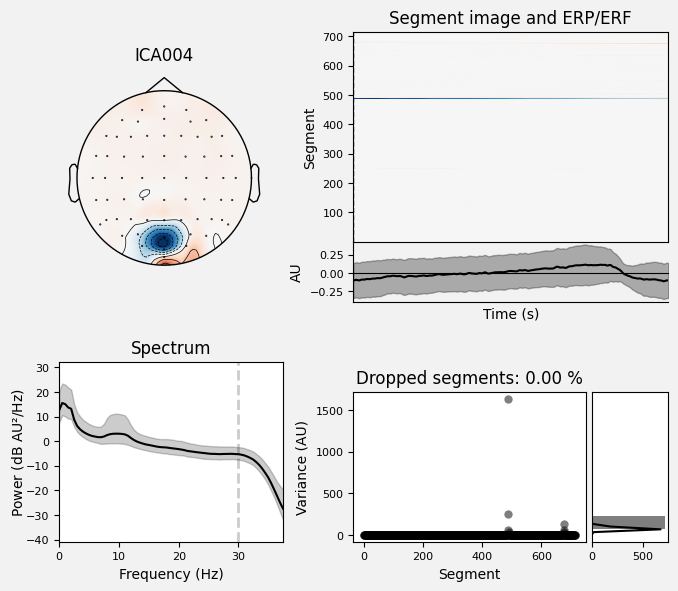

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [94]:
ica.plot_properties(raw, picks=[9,4])

In [95]:
print(ica.exclude)

[1, 0]


In [96]:
ica.exclude = [1,0,13,8,14,12,7,9,4]

In [97]:
print(ica.exclude)

[1, 0, 13, 8, 14, 12, 7, 9, 4]


Creating RawArray with float64 data, n_channels=7, n_times=2928640
    Range : 0 ... 2928639 =      0.000 ...  1430.000 secs
Ready.


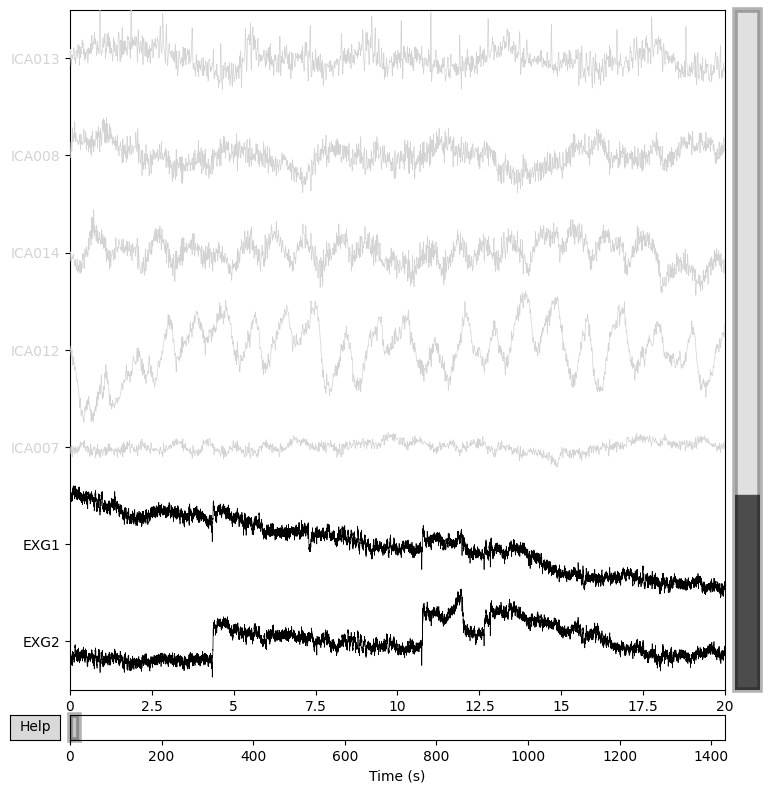

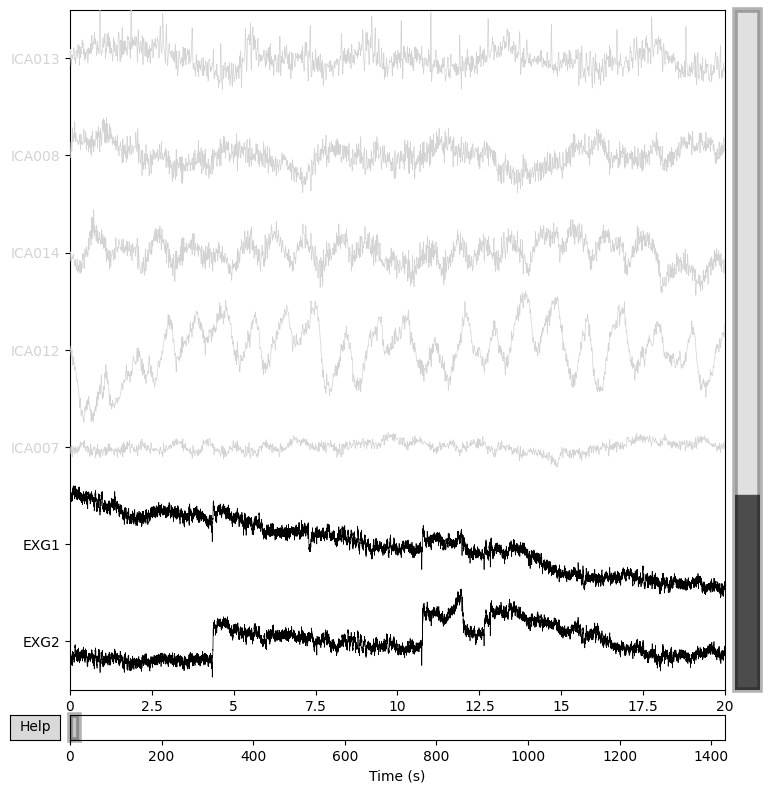

In [99]:
ica.plot_sources(raw, picks=ecg_indices)

In [100]:
reconstr_raw = raw.copy()
ica.apply(reconstr_raw)


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 9 ICA components
    Projecting back using 64 PCA components


<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GB, data loaded>

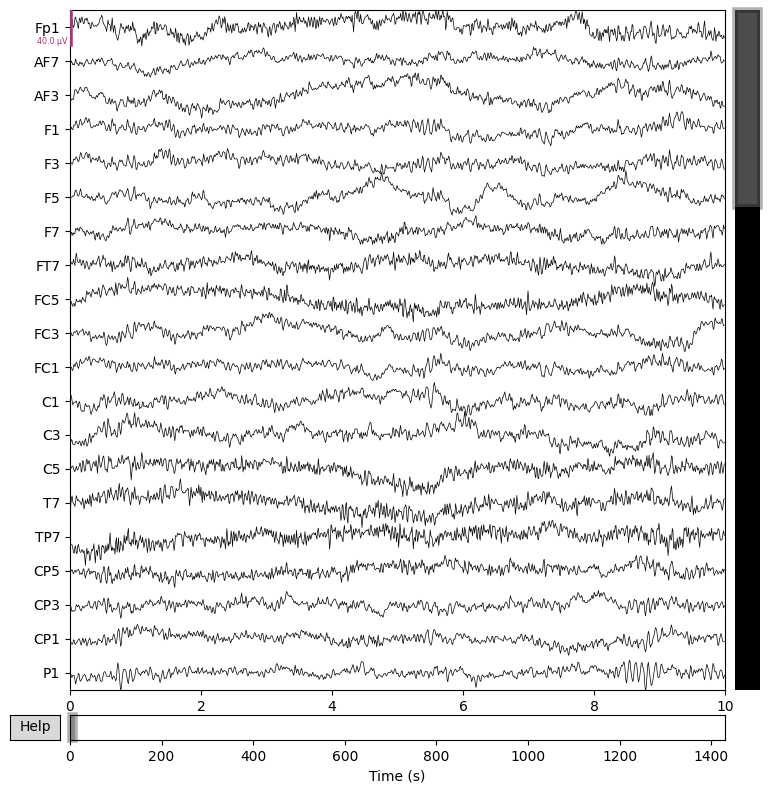

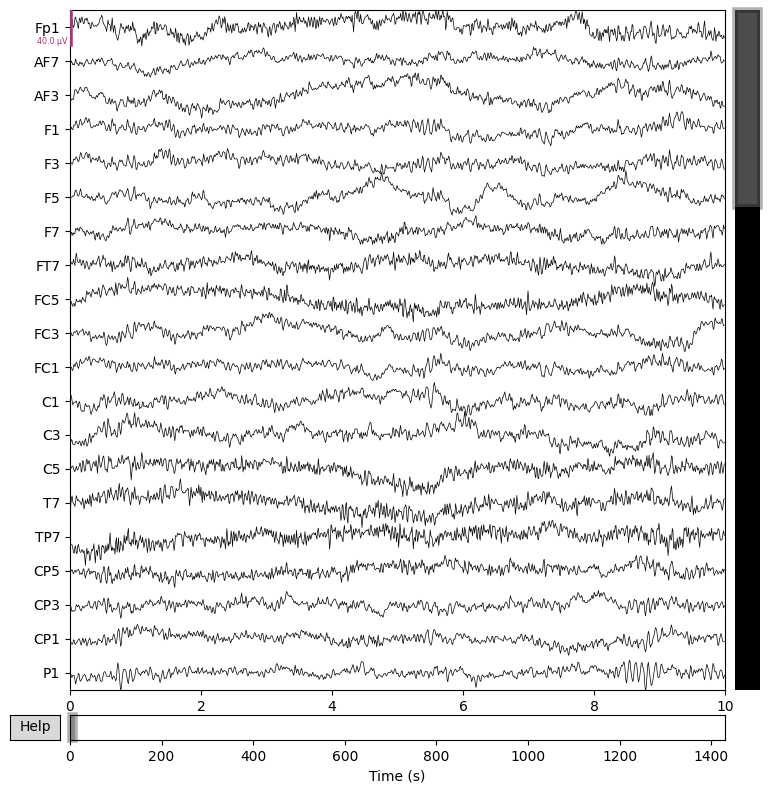

In [101]:
reconstr_raw.plot()

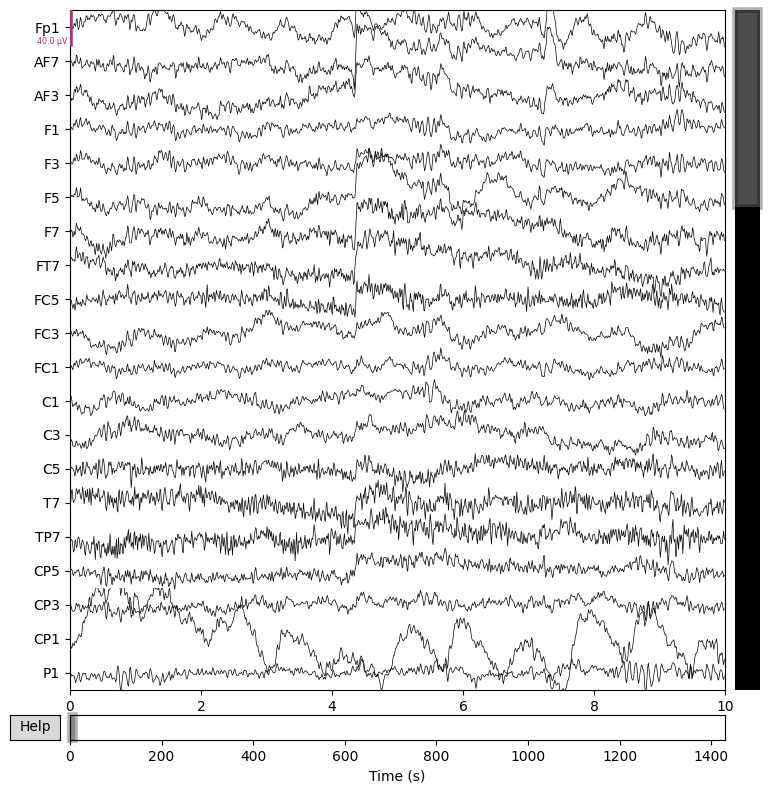

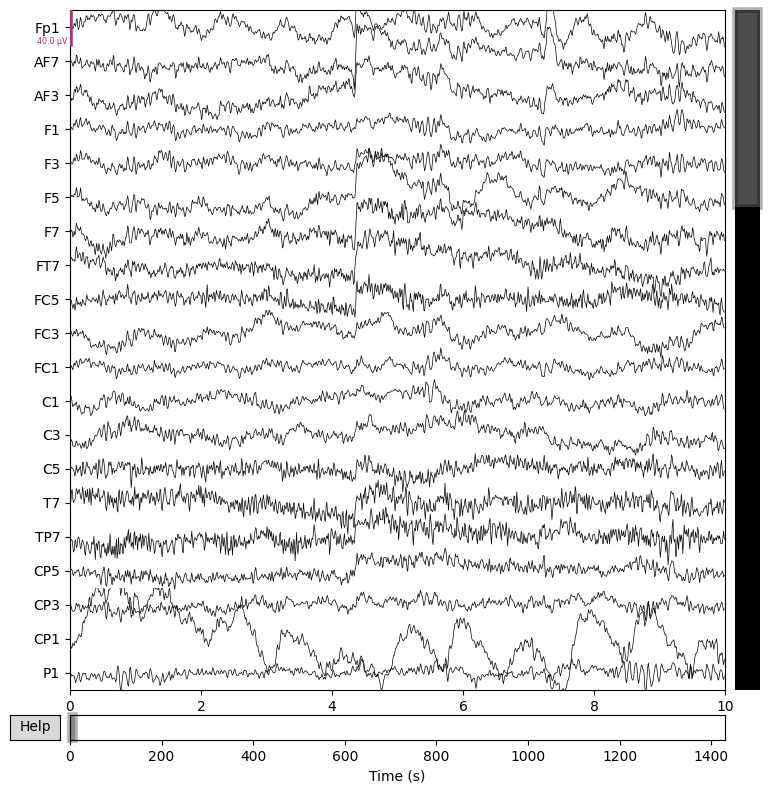

In [102]:
raw.plot()

In [106]:
import edfio
output_path = "/Users/szymbierz/Desktop/notebooks/statystyka/eeg/eeg_files/20241017_kp_cleaned.edf"
reconstr_raw.export(output_path,fmt="edf",overwrite=True)